# Figuring out MuRP

To do: 
- implement as single function
- attempt spatial decomp approach

In [71]:
from glob import glob
import xarray as xr
import rasterio as rio
import rioxarray
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [140]:
# define functions to read in data
def hyp3_to_xarray(path):
    '''
    Reads unwrapped phase, coherence, and DEM into xarray dataset from hyp3 folders. 
    '''
    # globs for data to load
    unw_phase_glob = glob(f'{path}/*/*unw_phase.tif')
    corr_glob = glob(f'{path}/*/*corr.tif')
    dem_glob = glob(f'{hyp3_path}/*/*dem.tif')[0]
    meta_glob = glob(f'{hyp3_path}/*/*.txt') # NEED TO ADD META TAG TO TEXT FILES

    # list granules for coordinate
    granule_list = [os.path.split(path)[-1][0:-14] for path in unw_phase_glob]

    # read metadata into dictionaries
    meta_list = []
    for i, path in enumerate(meta_glob):
        d = {}
        with open(meta_glob[0]) as f:
            for line in f:
                (key, val) = line.split(':')
                d[key] = str.strip(val)
        meta_list.append(d)

    # read unw_phase into data arrays and assign coordinates
    da_list = []
    for i, path in enumerate(unw_phase_glob):
        da = xr.open_dataset(path)
        for item in meta_list[i].keys():
            da = da.assign_coords({'granule':('granule', [granule_list[i]])})
            da = da.assign_coords({item:('granule', [meta_list[i][item]])})
        da_list.append(da)
    ds = xr.concat(da_list, dim='granule')

    ds = ds.rename({'band_data': 'unw_phase'})
    corr_ds = xr.concat([xr.open_dataset(f) for f in corr_glob], dim=granule_list)
    dem_ds = xr.open_dataset(dem_glob)

    ds['coherence'] = (('granule', 'band', 'y', 'x'), corr_ds.band_data.values)
    ds['elevation'] = (('band', 'y', 'x'), dem_ds.band_data.values)

    ds = ds.squeeze()

    return ds

In [144]:
hyp3_path = '../example_data'

In [145]:
ds = hyp3_to_xarray(hyp3_path)

In [163]:
def select_refs(ds, corr_thresh=0.8, n_refs=1000):
    ref_list = []
    ref_counter = 0
    coh_da = ds.coherence.mean(dim='granule')
    while ref_counter < n_refs:
        x, y = np.random.randint(0, len(ds.x)), np.random.randint(0, len(ds.y))
        if [x, y] not in ref_list:
            if coh_da.isel(x=x, y=y) >= corr_thresh:
                ref_list.append([x, y])
                ref_counter +=1
    return ref_list

In [164]:
%%time
refs = select_refs(ds)

CPU times: user 4.18 s, sys: 0 ns, total: 4.18 s
Wall time: 4.18 s


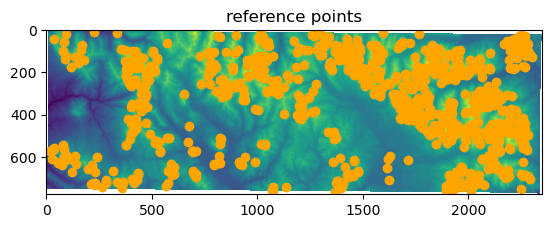

In [165]:
x, y = zip(*refs)

f, ax = plt.subplots()
ax.imshow(ds.elevation, cmap='viridis')
ax.plot(x, y, marker='o', linestyle='', color='Orange')
ax.set_title('reference points')
ax.set_aspect('equal')

In [166]:
def sample_refs(ds, refs):
    ref_values = []
    ref_elevation = []
    for ref in refs:
        ref_elevation.append(ds.elevation.isel(x=ref[0], y=ref[1]).item())
    for granule in ds.granule:
        ref_phase = []
        for ref in refs:
            ref_phase.append(ds.sel(granule=granule).unw_phase.isel(x=ref[0], y=ref[1]).item())
        ref_values.append(ref_phase)
    return ref_values, ref_elevation

In [167]:
%%time
ref_values, ref_elevation = sample_refs(ds, refs)

CPU times: user 40.4 s, sys: 8.57 ms, total: 40.4 s
Wall time: 40.4 s


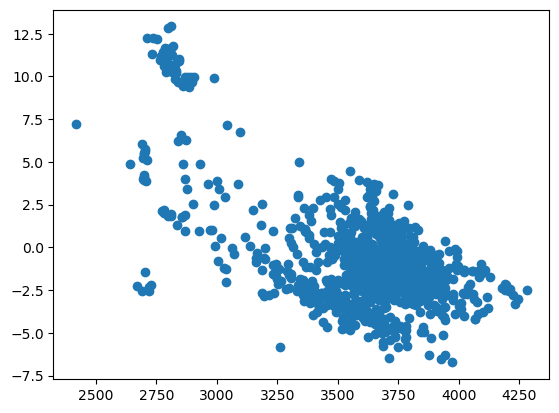

In [168]:
f, ax = plt.subplots()
ax.plot(ref_elevation, ref_values[0], marker='o', linestyle='')

In [280]:
def linear_fits(ds, ref_values, ref_elevation):
    fits = []
    for ref_phase in ref_values:
        model = linear_model.LinearRegression() 
        inputs = np.array((ref_elevation, ref_phase)).transpose()
        inputs = inputs[~np.isnan(inputs).any(axis=1)]
        model.fit(inputs[:, 0].reshape(-1, 1), inputs[:, 1])
        fits.append([model.coef_.item(), model.intercept_])
    return fits

In [281]:
%%time
fits = linear_fits(ds, ref_values, ref_elevation)

CPU times: user 21.3 ms, sys: 10.3 ms, total: 31.6 ms
Wall time: 29.4 ms


In [283]:
def correct_igrams(ds, fits):
    slope, intercept = zip(*fits)
    ds['unw_phase_c'] = ds.unw_phase - (ds.elevation.values[None, :, :]*np.array(slope)[:, None, None]+np.array(intercept)[:, None, None])
    return ds

In [284]:
ds = correct_igrams(ds, fits)

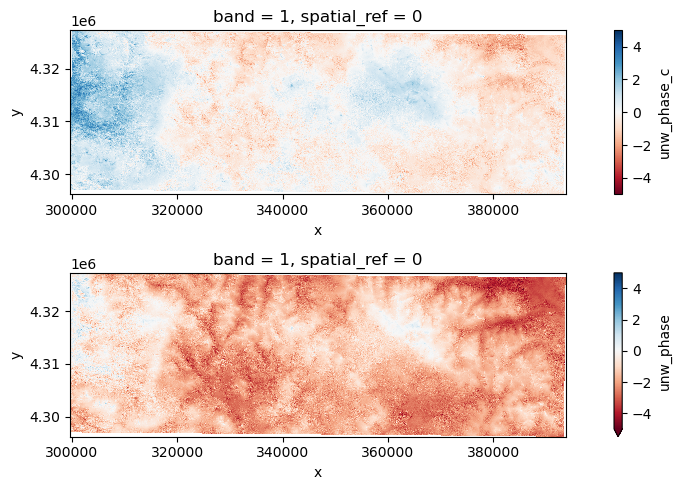

In [289]:
f, ax = plt.subplots(2, 1, figsize=(10, 5))
ds.unw_phase_c.mean(dim='granule').plot(ax=ax[0], vmin=-5, vmax=5, cmap='RdBu')
ax[0].set_aspect('equal')
ds.unw_phase.mean(dim='granule').plot(ax=ax[1], vmin=-5, vmax=5, cmap='RdBu')
ax[1].set_aspect('equal')
plt.tight_layout()